<a href="https://colab.research.google.com/github/sin4ch/anomaly-based-IDS-using-ML/blob/second-notebook/cicids_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load datasets

In [ ]:
# importing required libaries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 80)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score

import time
import pickle
import os

In [ ]:
data_path = '/content/drive/MyDrive/Colab_Notebooks/CICDS/MachineLearningCVE'
df_1 = pd.read_csv(data_path + '/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df_2 = pd.read_csv(data_path + '/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df_3 = pd.read_csv(data_path + '/Friday-WorkingHours-Morning.pcap_ISCX.csv')
df_4 = pd.read_csv(data_path + '/Monday-WorkingHours.pcap_ISCX.csv')
df_5 = pd.read_csv(data_path + '/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
df_6 = pd.read_csv(data_path + '/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df_7 = pd.read_csv(data_path + '/Tuesday-WorkingHours.pcap_ISCX.csv')
df_8 = pd.read_csv(data_path + '/Wednesday-workingHours.pcap_ISCX.csv')

# 1.0 Data Preprocessing

In [ ]:
# get shapes of each dataframe's
for i in range(1, 9):
    df_name = f'df_{i}'
    current_df = globals()[df_name]
    print(f"{df_name}: {current_df.shape}")
del df_name, current_df

df_1: (225745, 79)
df_2: (286467, 79)
df_3: (191033, 79)
df_4: (529918, 79)
df_5: (288602, 79)
df_6: (170366, 79)
df_7: (445909, 79)
df_8: (692703, 79)


### 1.1
* Data Concatenation
* Drop duplicated rows
* Drop features with constant values
* Fill missing values

In [ ]:
# Concatenates all data frames
main_df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8])
main_df = main_df.reset_index()


# Drop duplicates: same observation but multiple occurences
main_df.drop_duplicates(keep='first', inplace=True)


# Drop columns that have just one unique value, the model wil not learn form columns like this.
one_value = main_df.columns[main_df.nunique() == 1]
main_df.drop(columns = one_value, axis=1, inplace=True)


# Fill nan values
main_df['Flow Bytes/s'] = main_df['Flow Bytes/s'].fillna(main_df['Flow Bytes/s'].mean())


# Remove leading space character in all feature names
main_df.rename(columns=lambda x: x.lstrip(), inplace=True)


# Drop columns
main_df.drop(['Flow Packets/s', 'Flow Bytes/s'], axis=1, inplace=True)

main_df.shape

(2830731, 70)

In [ ]:
# Checking numbers of missing values on the df
main_df.isna().sum().sum()

0

In [ ]:
# delete df variables to free up space
del data_path, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, one_value

### 1.2 Extract subsample of data
Getting a subsample of the data, while taking every unique values in the Label(Target) column into consideration.

In [ ]:
main_df['Label'].value_counts()

Label
BENIGN                        2273085
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [ ]:
# Get sub sample of the dataframe, so as to reduce computation time.


# For each distinct class label in the Target column, create a dataframe for it
heartbleed = main_df[main_df['Label'] == 'Heartbleed']
Web_Attack_Sql_Injection = main_df[main_df['Label'] == 'Web Attack � Sql Injection']
Infiltration = main_df[main_df['Label'] == 'Infiltration']
Web_Attack_XSS = main_df[main_df['Label'] == 'Web Attack � XSS']
Web_Attack_Brute_Force = main_df[main_df['Label'] == 'Web Attack � Brute Force']
Bot = main_df[main_df['Label'] == 'Bot']
DoS_Slowhttptest = main_df[main_df['Label'] == 'DoS Slowhttptest']
DoS_slowloris = main_df[main_df['Label'] == 'DoS slowloris']
SSH_Patator = main_df[main_df['Label'] == 'SSH-Patator']
FTP_Patator = main_df[main_df['Label'] == 'FTP-Patator']
DoS_GoldenEye = main_df[main_df['Label'] == 'DoS GoldenEye']
DDoS = main_df[main_df['Label'] == 'DDoS']
PortScan = main_df[main_df['Label'] == 'PortScan']
DoS_Hulk = main_df[main_df['Label'] == 'DoS Hulk']
BENIGN = main_df[main_df['Label'] == 'BENIGN']


# extracting 100 of rows each from features with over 600 observations.
Web_Attack_XSS_sample = Web_Attack_XSS.sample(n=100)
Web_Attack_Brute_Force_sample = Web_Attack_Brute_Force.sample(n=100)
Bot_sample = Bot.sample(n=100)
DoS_slowloris_sample = DoS_slowloris.sample(n=100)
DoS_Slowhttptest_sample = DoS_Slowhttptest.sample(n=100)
DoS_slowloris_sample = DoS_slowloris.sample(n=100)
SSH_Patator_sample = SSH_Patator.sample(n=100)
FTP_Patator_sample = FTP_Patator.sample(n=100)
DoS_GoldenEye_sample = DoS_GoldenEye.sample(n=100)
DDoS_sample = DDoS.sample(n=100)
PortScan_sample = PortScan.sample(n=100)
DoS_Hulk_sample = DoS_Hulk.sample(n=100)
BENIGN_sample = BENIGN.sample(n=100)


# Concate sub sample observations to a dataframe
sample_df = pd.concat([heartbleed, Web_Attack_Sql_Injection, Infiltration, Web_Attack_XSS_sample, Web_Attack_Brute_Force_sample,
                       Bot_sample, DoS_Slowhttptest_sample, DoS_slowloris_sample, SSH_Patator_sample, FTP_Patator_sample,
                       DoS_GoldenEye_sample, DDoS_sample, PortScan_sample, DoS_Hulk_sample, BENIGN_sample])
sample_df.shape

(1268, 70)

In [ ]:
# del variables to free up memory
del heartbleed, Web_Attack_Sql_Injection, Infiltration, Web_Attack_XSS_sample, Web_Attack_Brute_Force_sample, Bot_sample, DoS_Slowhttptest_sample, DoS_slowloris_sample, SSH_Patator_sample, FTP_Patator_sample, DoS_GoldenEye_sample, DDoS_sample, PortScan_sample, DoS_Hulk_sample, BENIGN_sample
del Web_Attack_XSS, Web_Attack_Brute_Force, Bot, DoS_Slowhttptest, DoS_slowloris, SSH_Patator, FTP_Patator, DoS_GoldenEye, DDoS, PortScan, DoS_Hulk, BENIGN
del main_df

In [ ]:
sample_df['Label'].value_counts()

Label
Web Attack � XSS              100
Web Attack � Brute Force      100
Bot                           100
DoS Slowhttptest              100
DoS slowloris                 100
SSH-Patator                   100
FTP-Patator                   100
DoS GoldenEye                 100
DDoS                          100
PortScan                      100
DoS Hulk                      100
BENIGN                        100
Infiltration                   36
Web Attack � Sql Injection     21
Heartbleed                     11
Name: count, dtype: int64

## 1.3 Label Encoder and Data Scaling

In [ ]:
le = LabelEncoder()
sample_df['Label'] = le.fit_transform(sample_df['Label'])
sample_df.drop(['index'], axis=1, inplace=True)

# Data Spliting

In [ ]:
X = sample_df.drop(columns=['Label'], axis=1)
y = sample_df['Label']

# Initial train test split set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split training set into training (70%) and validation (10%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

# Display the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (912, 68)
Validation set shape: (102, 68)
Testing set shape: (254, 68)


In [ ]:
# del sample_df to free up memory
del sample_df, X, y

In [ ]:
def model_training_time(model_name: str, total_time: float):
  '''
  Save model training time and name, and to load for future data analysis.
  '''
  try:
    time_taken = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CICDS/Models/time_taken.csv')
  except FileNotFoundError:
    time_taken = pd.DataFrame(columns=['Model Name', 'Time'])

  # Append new data to df
  new_data = pd.DataFrame({'Model Name': [model_name], 'Time': [total_time]})
  time_taken = pd.concat([time_taken, new_data], ignore_index=True)

  # Save updated DataFrame to CSV
  time_taken.to_csv('/content/drive/MyDrive/Colab_Notebooks/CICDS/Models/time_taken.csv', index=False)

# Model Training

### XGBoost

In [ ]:
# Train on GPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

xgb_start_train = time.time() # Start time

# xgb_model = xgb.XGBClassifier(tree_method='hist', device=device, num_class=8) # Uncomment of run on GPU
xgb_model = xgb.XGBClassifier(num_class=8) # uncomment to run on CPU
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

xgb_end_train = time.time() # End time
xgb_training_time = xgb_end_train - xgb_start_train # Total model training time


# Testing
xgb_start_test = time.time()
y_pred_xgb = xgb_model.predict(X_test)
acc_test_xgb = accuracy_score(y_test, y_pred_xgb)
xgb_end_test = time.time()
xgb_testing_time = xgb_end_test - xgb_start_test


# Validation
xgb_start_validation = time.time()
xgb_y_val =  xgb_model.predict(X_val)
xgb_val_acc = accuracy_score(y_val, xgb_y_val)
xgb_end_validation = time.time()
xgb_validation_time = xgb_end_validation - xgb_start_validation

### KNN

In [ ]:
knn_file_path = '/content/drive/MyDrive/Colab_Notebooks/CICDS/Models/knn_model.sav'


# Create path if not existed, time the KNN training time and save model.
if not os.path.isfile(knn_file_path):
  knn_start_time = time.time()                              # start time

  knn = KNeighborsClassifier()
  knn.fit(X_train, y_train)

  knn_end_time = time.time()                                # end time
  knn_training_time = knn_end_time - knn_start_time         # knn_training_time
  model_training_time(type(knn).__name__, knn_training_time)

  pickle.dump(knn, open(knn_file_path, 'wb'))               # dump model to path


# If path already existed, just Load and test, val data.
if os.path.isfile(knn_file_path):
  knn = pickle.load(open(knn_file_path, 'rb'))

  # Testing
  knn_start_test = time.time()

  knn_y_test = knn.predict(X_test)
  knn_test_acc = accuracy_score(y_test, knn_y_test)

  knn_end_test = time.time()
  knn_testing_time = knn_end_test - knn_start_test


  # Validation
  knn_start_validation = time.time()

  knn_y_val =  knn.predict(X_val)
  knn_val_acc = accuracy_score(y_val, knn_y_val)

  knn_end_validation = time.time()
  knn_validation_time = knn_end_validation - knn_start_validation

### Decison Tree

In [ ]:
dt_file_path = '/content/drive/MyDrive/Colab_Notebooks/CICDS/Models/dt_model.sav'

if not os.path.isfile(dt_file_path):
  dt_start_time = time.time()                 # start time
  dt = DecisionTreeClassifier()
  dt.fit(X_train, y_train)
  dt_end_time = time.time()                    # end time
  dt_training_time = dt_end_time - dt_start_time
  model_training_time(type(dt).__name__, dt_training_time)
  pickle.dump(dt, open(dt_file_path, 'wb'))



if os.path.isfile(dt_file_path):
  # Load and test, val data
  dt = pickle.load(open(dt_file_path, 'rb'))

  # Testing
  dt_start_test = time.time()

  dt_y_test = dt.predict(X_test)
  dt_test_acc = accuracy_score(y_test, dt_y_test)

  dt_end_test = time.time()
  dt_testing_time = dt_end_test - dt_start_test


  # Validation
  dt_start_validation = time.time()

  dt_y_val =  dt.predict(X_val)
  dt_val_acc = accuracy_score(y_val, dt_y_val)

  dt_end_validation = time.time()
  dt_validation_time = dt_end_validation - dt_start_validation

### Random Forest

In [ ]:
import os
rf_file_path = '/content/drive/MyDrive/Colab_Notebooks/CICDS/Models/rf_model.sav'

if not os.path.isfile(rf_file_path):
  rf_start_time = time.time()                 # start time

  rf = RandomForestClassifier()
  rf.fit(X_train, y_train)

  rf_end_time = time.time()                    # end time

  rf_training_time = rf_end_time - rf_start_time
  model_training_time(type(rf).__name__, rf_training_time)
  pickle.dump(rf, open(rf_file_path, 'wb'))


if os.path.isfile(rf_file_path):
  # Load and test, val data
  rf = pickle.load(open(rf_file_path, 'rb'))

  # Testing
  rf_start_test = time.time()

  rf_y_test = rf.predict(X_test)
  rf_test_acc = accuracy_score(y_test, rf_y_test)

  rf_end_test = time.time()
  rf_testing_time = rf_end_test - rf_start_test


  # Validation
  rf_start_validation = time.time()

  rf_y_val =  rf.predict(X_val)
  rf_val_acc = accuracy_score(y_val, rf_y_val)

  rf_end_validation = time.time()
  rf_validation_time = rf_end_validation - rf_start_validation

## Model Analysis

In [ ]:
models_training_time = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/CICDS/Models/time_taken.csv')

new_data = pd.DataFrame({'Model Name': [type(xgb_model).__name__], 'Time': [xgb_training_time]})

# Append new data to the existing DataFrame
models_training_time_1 = models_training_time.copy()
models_training_time_1 = pd.concat([models_training_time, new_data], axis=0)
models_training_time_1

,Model Name,Time
0,KNeighborsClassifier,0.004062
1,DecisionTreeClassifier,0.035476
2,RandomForestClassifier,0.321845
0,XGBClassifier,4.270574


In [ ]:
knn_time = models_training_time_1['Time'].iloc[0]
dt_time = models_training_time_1['Time'].iloc[1]
rf_time = models_training_time_1['Time'].iloc[2]
xgb_time = models_training_time_1['Time'].iloc[3]

## Data Plotting

In [ ]:
models = ['K Nearest Neighbor', 'Decision Tree', 'Random Forest', 'XGBoost']
training_time = [knn_time, dt_time, rf_time, xgb_time]
test_accuracy = [knn_test_acc, dt_test_acc, rf_test_acc, acc_test_xgb]
validation_accuracy = [knn_val_acc, dt_val_acc, rf_val_acc, xgb_val_acc]


# Creating a dataframe
data = {'Model': models, 'Training Time (s)': training_time, 'Test Accuracy': test_accuracy, 'Validation Accuracy': validation_accuracy}
df = pd.DataFrame(data)
df

,Model,Training Time (s),Test Accuracy,Validation Accuracy
0,K Nearest Neighbor,0.004062,0.814961,0.754902
1,Decision Tree,0.035476,0.921260,0.862745
2,Random Forest,0.321845,0.917323,0.901961
3,XGBoost,4.270574,0.897638,0.882353


In [ ]:
df['Model'].tolist()

['K Nearest Neighbor', 'Decision Tree', 'Random Forest', 'XGBoost']

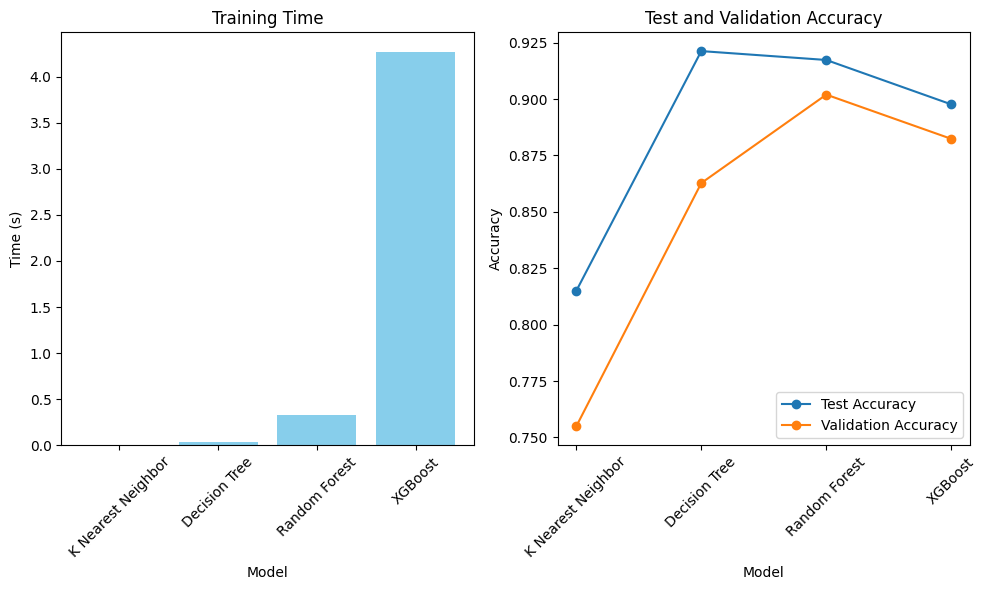

In [ ]:
# Visualizing the data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plotting training time
plt.subplot(1, 2, 1)
plt.bar(df['Model'], df['Training Time (s)'], color='skyblue')
plt.title('Training Time')
plt.xlabel('Model')
plt.ylabel('Time (s)')
plt.xticks(rotation=45)

# Plotting test and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(df['Model'], df['Test Accuracy'], marker='o', label='Test Accuracy')
plt.plot(df['Model'], df['Validation Accuracy'], marker='o', label='Validation Accuracy')
plt.title('Test and Validation Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

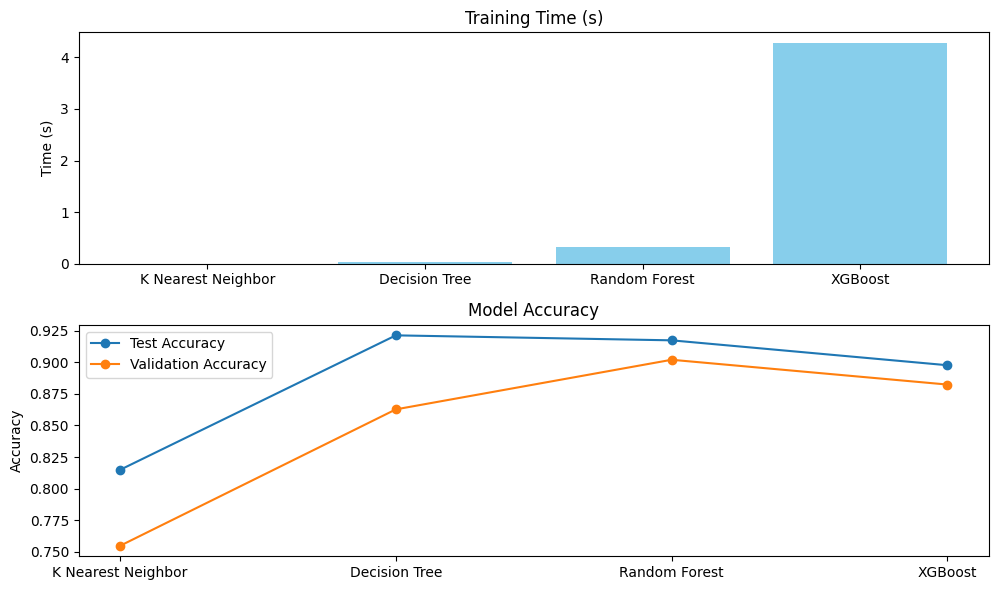

In [ ]:
import matplotlib.pyplot as plt

models = df['Model'].tolist()
training_time = df['Training Time (s)'].tolist()
test_accuracy = df['Test Accuracy'].tolist()
validation_accuracy = df['Validation Accuracy'].tolist()

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.bar(models, training_time, color='skyblue')
plt.title('Training Time (s)')
plt.ylabel('Time (s)')

plt.subplot(2, 1, 2)
plt.plot(models, test_accuracy, marker='o', label='Test Accuracy')
plt.plot(models, validation_accuracy, marker='o', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


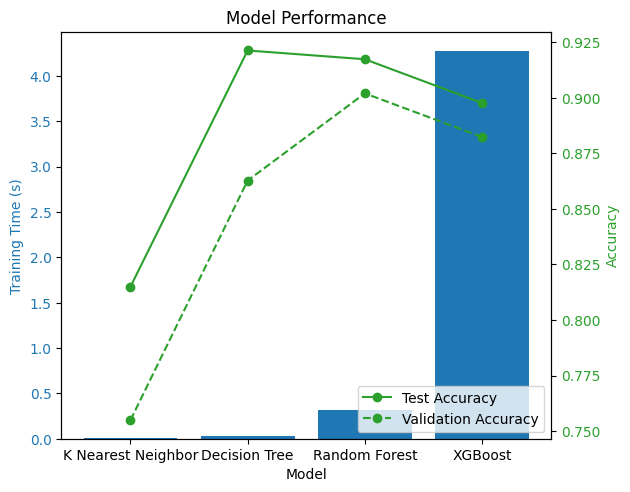

In [ ]:
import matplotlib.pyplot as plt

models = df['Model'].tolist()
training_time = df['Training Time (s)'].tolist()
test_accuracy = df['Test Accuracy'].tolist()
validation_accuracy = df['Validation Accuracy'].tolist()

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Training Time (s)', color=color)
ax1.bar(models, training_time, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(models, test_accuracy, marker='o', label='Test Accuracy', color=color)
ax2.plot(models, validation_accuracy, marker='o', label='Validation Accuracy', linestyle='dashed', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Model Performance')
plt.legend()
plt.show()


# Evaluation metrics